# UT4 – Datos Especiales  
## Análisis geoespacial de delitos en la ciudad de Chicago - Caso extra
En este ejercicio se trabajó con **datos geoespaciales reales**, utilizando *GeoPandas*, *Shapely* y *Contextily* para construir un pipeline reproducible capaz de:

- Manipular datos espaciales (puntos georreferenciados).  
- Convertir datos tabulares a `GeoDataFrame`.  
- Trabajar con sistemas de coordenadas (CRS).  
- Generar visualizaciones urbanas para detección de *hotspots*.  

Este notebook utiliza el dataset abierto **"Crimes in Chicago"**, accedido vía API, sin necesidad de subir archivos.

In [22]:
!pip install geopandas contextily shapely pyproj --quiet

In [23]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

### 🔽 Descarga de datos reales desde el portal de Chicago

Se usa la API pública del gobierno de Chicago.  
Descargamos una **muestra reciente de incidentes delictivos**, incluyendo:

- Tipo de delito  
- Coordenadas  
- Hora y ubicación aproximada  

Trabajamos con una muestra para mantener el notebook liviano.

In [24]:
url = (
    "https://data.cityofchicago.org/resource/ijzp-q8t2.csv"
    "?$limit=15000"
    "&$select=primary_type,latitude,longitude,block,date"
)

crimes = pd.read_csv(url)
crimes.head()

,primary_type,latitude,longitude,block,date
0,MOTOR VEHICLE THEFT,41.879643,-87.666751,001XX S ASHLAND AVE,2025-11-29T00:00:00.000
1,ASSAULT,41.745881,-87.597285,011XX E 82ND ST,2025-11-29T00:00:00.000
2,BURGLARY,41.753496,-87.650181,077XX S CARPENTER ST,2025-11-29T00:00:00.000
3,THEFT,41.892970,-87.759822,053XX W HURON ST,2025-11-29T00:00:00.000
4,CRIMINAL DAMAGE,41.972275,-87.687435,023XX W ARGYLE ST,2025-11-29T00:00:00.000


### 🧹 Limpieza básica del dataset

Eliminamos filas sin coordenadas y reseteamos el índice.  
Esto es crucial antes de crear el `GeoDataFrame`.

In [25]:
crimes = crimes.dropna(subset=["latitude", "longitude"]).reset_index(drop=True)
crimes.shape

(14933, 5)

### 🌍 Conversión a datos geoespaciales

Transformamos la tabla en un `GeoDataFrame`, creando una geometría `Point` por cada incidente.

Luego establecemos un **CRS geográfico (EPSG:4326)**.

In [26]:
gdf = gpd.GeoDataFrame(
    crimes,
    geometry=gpd.points_from_xy(crimes.longitude, crimes.latitude),
    crs="EPSG:4326"
)

gdf.head()

,primary_type,latitude,longitude,block,date,geometry
0,MOTOR VEHICLE THEFT,41.879643,-87.666751,001XX S ASHLAND AVE,2025-11-29T00:00:00.000,POINT (-87.66675 41.87964)
1,ASSAULT,41.745881,-87.597285,011XX E 82ND ST,2025-11-29T00:00:00.000,POINT (-87.59728 41.74588)
2,BURGLARY,41.753496,-87.650181,077XX S CARPENTER ST,2025-11-29T00:00:00.000,POINT (-87.65018 41.7535)
3,THEFT,41.892970,-87.759822,053XX W HURON ST,2025-11-29T00:00:00.000,POINT (-87.75982 41.89297)
4,CRIMINAL DAMAGE,41.972275,-87.687435,023XX W ARGYLE ST,2025-11-29T00:00:00.000,POINT (-87.68743 41.97227)


### 🗺️ Reproyección a Web Mercator (EPSG:3857)

Los mapas base (basemaps) requieren un CRS proyectado.  
Usamos **EPSG:3857**, el estándar de la mayoría de los mapas digitales.

In [27]:
gdf_3857 = gdf.to_crs(epsg=3857)
gdf_3857.head()

,primary_type,latitude,longitude,block,date,geometry
0,MOTOR VEHICLE THEFT,41.879643,-87.666751,001XX S ASHLAND AVE,2025-11-29T00:00:00.000,POINT (-9759018.101 5142967.638)
1,ASSAULT,41.745881,-87.597285,011XX E 82ND ST,2025-11-29T00:00:00.000,POINT (-9751285.153 5122989.265)
2,BURGLARY,41.753496,-87.650181,077XX S CARPENTER ST,2025-11-29T00:00:00.000,POINT (-9757173.496 5124125.579)
3,THEFT,41.892970,-87.759822,053XX W HURON ST,2025-11-29T00:00:00.000,POINT (-9769378.669 5144960.308)
4,CRIMINAL DAMAGE,41.972275,-87.687435,023XX W ARGYLE ST,2025-11-29T00:00:00.000,POINT (-9761320.608 5156827.276)


###Visualizaciones

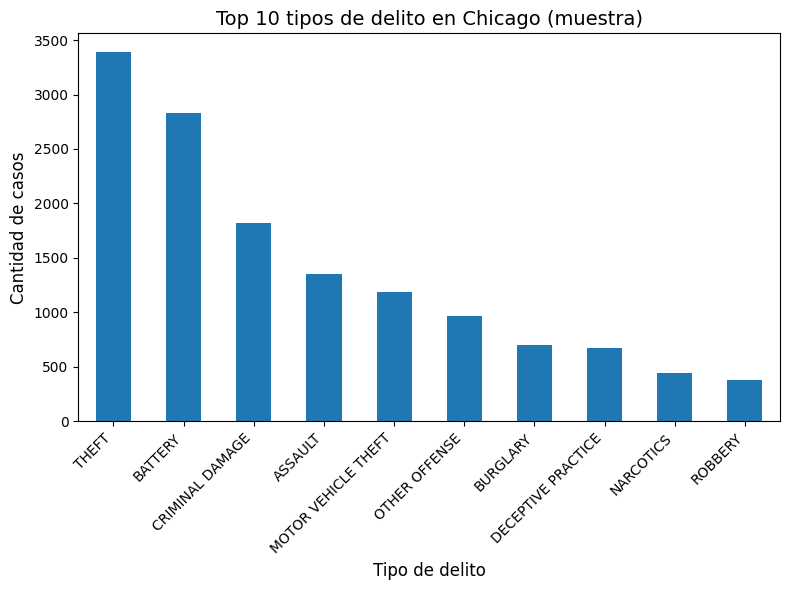

In [28]:
top_types = gdf["primary_type"].value_counts().head(10)

ax = top_types.plot(kind="bar")
ax.set_title("Top 10 tipos de delito en Chicago (muestra)")
ax.set_ylabel("Cantidad de casos")
ax.set_xlabel("Tipo de delito")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

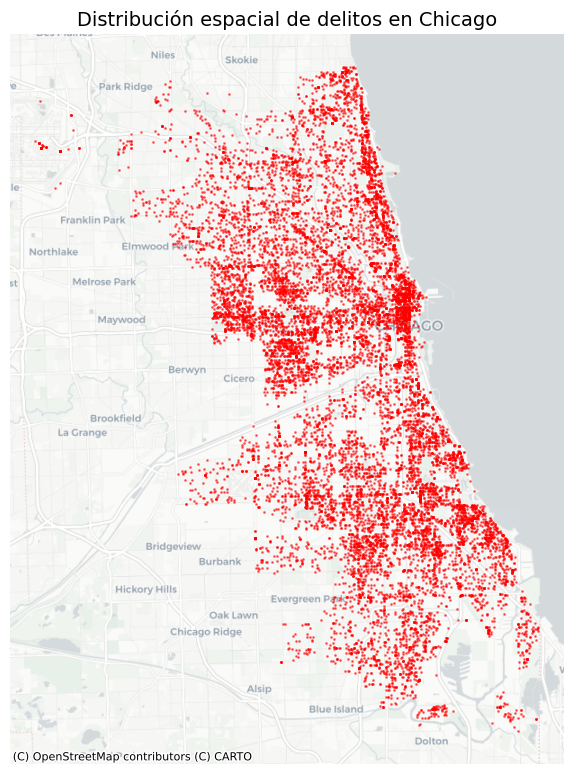

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf_3857.plot(ax=ax, markersize=1, alpha=0.5, color="red")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Distribución espacial de delitos en Chicago")
ax.set_axis_off()

plt.tight_layout()
plt.show()

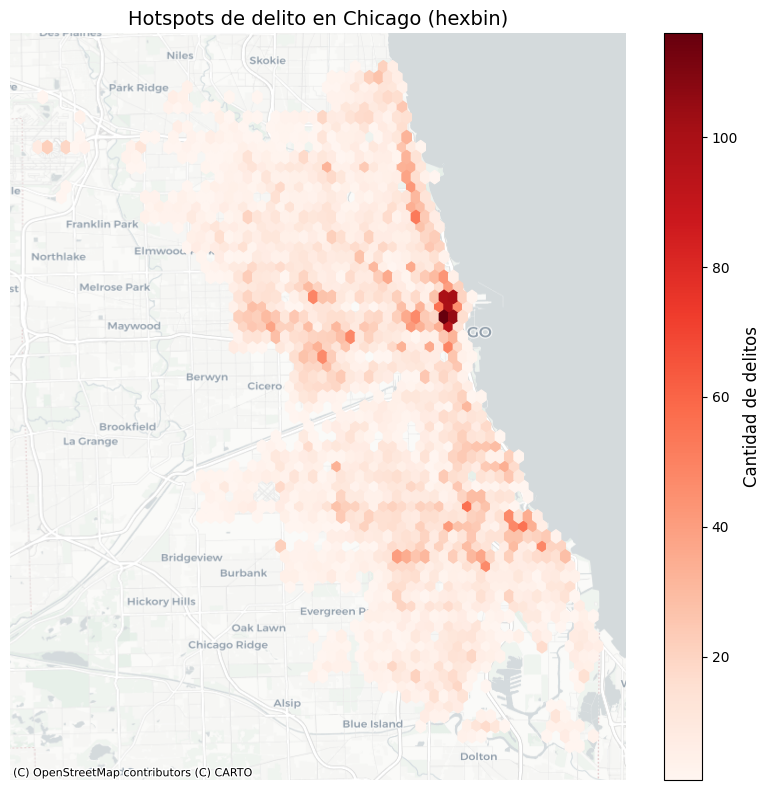

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_3857.geometry.x,
    gdf_3857.geometry.y,
    gridsize=60,
    mincnt=1,
    cmap="Reds"
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Hotspots de delito en Chicago (hexbin)")
ax.set_axis_off()

cb = fig.colorbar(hb, ax=ax, label="Cantidad de delitos")
plt.tight_layout()
plt.show()

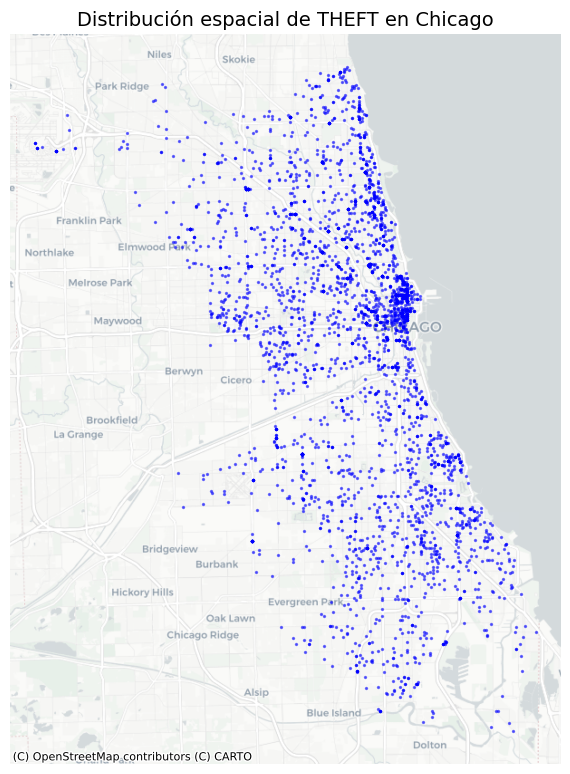

In [31]:
theft = gdf_3857[gdf_3857["primary_type"] == "THEFT"]

fig, ax = plt.subplots(figsize=(8, 8))
theft.plot(ax=ax, markersize=2, alpha=0.5, color="blue")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Distribución espacial de THEFT en Chicago")
ax.set_axis_off()

plt.tight_layout()
plt.show()

### 📐 Resumen cuantitativo

Calculamos porcentajes básicos para complementar el análisis visual.

In [32]:
total_crimes = len(gdf)
theft_count = len(theft)
theft_pct = theft_count / total_crimes * 100

print(f"Total de incidentes en la muestra: {total_crimes}")
print(f"Incidentes de THEFT: {theft_count} ({theft_pct:.1f}%)")

Total de incidentes en la muestra: 14933
Incidentes de THEFT: 3392 (22.7%)
